# Exploring Demographic Predictors of OCD Comorbidity with Synthetic Data

## Introduction

Obsessive-Compulsive Disorder (OCD) is a complex mental health condition characterized by irrational thoughts and fears (obsessions) that lead to repetitive behaviors (compulsions). It often co-occurs with other mental health conditions such as Anxiety, Depression, or even both. Uncovering and understanding any demographic patterns associated with these comorbidities may help shed light on patterns of vulnerability and treatment needs.

In this project, I worked with a kaggle-sourced *synthetic dataset of 1500 simulated OCD patients*. The dataset includes demographic, clinical, and diagnostic factors of these synthetic patients. The goal of this project was to explore whether demographic factors (age, gender, education level, marital status, and ethnicity) could meaningfully predict OCD comorbidities (Anxiety, Depression, Both, or None).

## Data Loading and Overview

In [1]:
# importing the relevant libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [2]:
# Loading the dataset

df = pd.DataFrame(pd.read_csv("ocd_patient_dataset.csv"))
df = df.rename(columns={"Gender": "Sex"})
print("(Rows, Columns) - ",df.shape)
df.head()

(Rows, Columns) -  (1500, 17)


,Patient ID,Age,Sex,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
0,1018,32,Female,African,Single,Some College,2016-07-15,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2406,69,Male,African,Divorced,Some College,2017-04-28,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,1188,57,Male,Hispanic,Divorced,College Degree,2018-02-02,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,6200,27,Female,Hispanic,Married,College Degree,2014-08-25,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,5824,56,Female,Hispanic,Married,High School,2022-02-20,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN


**Note: The original dataset column labeled `Gender` has been renamed to `Sex` to more accurately reflect that it represents biological sex assigned at birth (Male/Female) in this synthetic dataset. This distinction is important to clarify that the column does not capture gender identity,which can be much more diverse.**  


The full dataset has 1500 rows and 17 columns. Each row represents the data of one synthetic patient, and each column represents a demographic, clinical, or medical variable recorded for all the patients. For this project, the following variables are of interest:

1. Age (int) - Current age of the patient, ranging from 18 years (youngest) to 75 years (oldest)
2. Sex (str) - Biological sex assigned at birth (Male or Female) 
3. Ethnicity (str) - Ethnic background of the patient (African, Asian, Caucasian, Hispanic)
4. Marital Status (str) - Current marital status of the patient (Single, Divorced, Married)
5. Education Level (str) - Highest level of education attained by the patient (High School, Some College, 
                            College Degree, Graduate Degree)
6. Depression Diagnosis (str) - Whether or not the patient has been clinically diagnosed with Depression,
                                *alongside* OCD
7. Anxiety Diagnosis (str) - Whether or not the patient has been clinically diagnosed with Anxiety, 
                                *alongside* OCD

## Data Cleaning and Preprocessing

**1. Feature Selection:**  

The first step in preprocessing is selecting only the relevant columns for analysis. From the full dataset, we retain demographic features (`Age`, `Sex`, `Ethnicity`, `Marital Status`, `Education Level`) and clinical diagnosis labels (`Depression Diagnosis`, `Anxiety Diagnosis`) to create a working dataframe for subsequent modeling and analysis.


In [3]:
# Only extracting the columns that are relevant for this project

dem_co_df = df.copy()[["Age", "Sex", "Ethnicity", "Marital Status", "Education Level", 
                       "Depression Diagnosis", "Anxiety Diagnosis"]
]
dem_co_df.head()

,Age,Sex,Ethnicity,Marital Status,Education Level,Depression Diagnosis,Anxiety Diagnosis
0,32,Female,African,Single,Some College,Yes,Yes
1,69,Male,African,Divorced,Some College,Yes,Yes
2,57,Male,Hispanic,Divorced,College Degree,No,No
3,27,Female,Hispanic,Married,College Degree,Yes,Yes
4,56,Female,Hispanic,Married,High School,No,No


**2. Missing Values:**  

Next step was to check the dataset for any missing values (`NaN`/`None`). Since there were **no missing values** in the selected features, no imputation was required.


In [4]:
#Checking for missing data

dem_co_df.isna().any()

Age                     False
Sex                     False
Ethnicity               False
Marital Status          False
Education Level         False
Depression Diagnosis    False
Anxiety Diagnosis       False
dtype: bool

**3. Binary Encoding:**  

The `Depression Diagnosis` and `Anxiety Diagnosis` columns originally contain categorical values (`Yes`/`No`). These columns are converted to numeric binary values (`1` for Yes, `0` for No) to facilitate modeling and analysis.

In [5]:
dem_co_df["Depression Diagnosis"] = dem_co_df["Depression Diagnosis"].apply(
    lambda x: 1 if x == "Yes" else 0
)
dem_co_df["Anxiety Diagnosis"] = dem_co_df["Anxiety Diagnosis"].apply(
    lambda x: 1 if x == "Yes" else 0
)

**4. Creating Co-Occurrence Labels:**  

To facilitate multi-class analysis, two new binary columns are generated:  
- `Both`: Indicates patients with **both depression and anxiety** (`1` if both present, `0` otherwise).  
- `None`: Indicates patients with **neither depression nor anxiety** (`1` if neither present, `0` otherwise).  

These derived columns help define the full set of OCD co-occurring condition categories: `Depression Only`, `Anxiety Only`, `Both`, and `None`.

In [6]:
dem_co_df["Both"] = (dem_co_df["Depression Diagnosis"] + dem_co_df["Anxiety Diagnosis"]).apply(
    lambda x: 1 if x == 2 else 0
)

dem_co_df["None"] = (dem_co_df["Depression Diagnosis"] + dem_co_df["Anxiety Diagnosis"]).apply(
    lambda x: 1 if x == 0 else 0
)

#Making sure that if a patient gets marked into "Both", then they are removed from the "Depression
# Only" and the "Anxiety Only" columns

both_df = dem_co_df.copy()[dem_co_df["Both"] == 1]
both_df["Depression Diagnosis"] = both_df["Depression Diagnosis"].apply(lambda x: 0)
both_df["Anxiety Diagnosis"] = both_df["Anxiety Diagnosis"].apply(lambda x: 0)
single_none_df = dem_co_df[dem_co_df["Both"] != 1]
dem_co_df = pd.concat([both_df, single_none_df])
dem_co_df.head()



,Age,Sex,Ethnicity,Marital Status,Education Level,Depression Diagnosis,Anxiety Diagnosis,Both,None
0,32,Female,African,Single,Some College,0,0,1,0
1,69,Male,African,Divorced,Some College,0,0,1,0
3,27,Female,Hispanic,Married,College Degree,0,0,1,0
5,32,Female,Asian,Married,College Degree,0,0,1,0
9,72,Female,Hispanic,Divorced,Graduate Degree,0,0,1,0


**5. Renaming Columns for Clarity:**  

The original columns `Depression Diagnosis` and `Anxiety Diagnosis` are renamed to `Depression Only` and `Anxiety Only` to clearly indicate that these columns represent patients with **only depression** or **only anxiety**, excluding cases where these OCD comorbidities co-occur. This makes the dataset more interpretable for multi-class analysis.

In [7]:
dem_co_df = dem_co_df.rename(columns={
    "Depression Diagnosis":"Depression Only",
    "Anxiety Diagnosis":"Anxiety Only"
})

**6. Feature Encoding & Preparation:**  

Finally, the categorical features (`Sex`, `Ethnicity`, `Marital Status`, `Education Level`) are one-hot encoded. We now have a fully numeric dataset ready for modeling and analysis.

In [8]:
one_hot_vars = pd.get_dummies(dem_co_df[["Sex", "Ethnicity", 
    "Marital Status", "Education Level"]])
one_hot_vars = one_hot_vars.apply(lambda x: x + 0)
preprocessed_df = pd.concat(
    [dem_co_df[["Age", "Depression Only", "Anxiety Only", "Both", "None"]],
    one_hot_vars],
    axis=1
)
preprocessed_df.head()

,Age,Depression Only,Anxiety Only,Both,None,Sex_Female,Sex_Male,Ethnicity_African,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Hispanic,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Education Level_College Degree,Education Level_Graduate Degree,Education Level_High School,Education Level_Some College
0,32,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1
1,69,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1
3,27,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0
5,32,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0
9,72,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0


## Exploratory Data Analysis (EDA)

To gain insights into the demographic and clinical patterns in our dataset, we perform an exploratory data analysis (EDA). The analysis is structured to move from broad descriptive summaries to more detailed interactions between variables.

We begin by examining the overall distribution of OCD co-occurring conditions (Anxiety Only, Depression Only, Both, None). Next, we compare how these conditions are associated with demographic factors such as age, sex, ethnicity, education level, and marital status. Finally, we explore higher-order interactions between variables to uncover deeper structural patterns in the data.

The steps of the EDA are as follows:

1. <u>Overall Proportion of Comorbidities</u><br>Pie chart and summary table of Depression Only, Anxiety Only, Both, None.



2. <u>Age-wise Distributions</u><br>a. Grouped boxplot of comorbidities across sex.<br>b. Grouped boxplot of comorbidities across ethnicity



3. <u>Demographic Comparisons (Categorical)</u><br>a. Grouped bar chart of comorbidities by education level.<br>b. Grouped bar chart of comorbidities by marital status.



4. <u>Interactions Between Demographics</u><br>a. Heatmap of comorbidities across combined sex and ethnicity.<br>b. Mosaic plot of education × marital status × comorbities.



5. <u>Multi-level Flow Representation</u><br>a. Sankey diagram illustrating pathways from ethnicity → education level → marital status → comorbidities.

In [9]:
#assigning colors to maintain consistency across all graphs
colors_comorbid = {
    "Depression Only": "#c51b8a",
    "Anxiety Only": "#fbb2f8",
    "Both": "#7a0177",
    "None": "#fa9fb5"
}
colors_sex = {
    "Female": "#ff7b98",
    "Male": "#94f5eb"
}
colors_ethn = {
    "African": "#dcfbae", 
    "Asian": "#3fd790",         
    "Caucasian": "#3c975d",     
    "Hispanic": "#95e4a3"
}
colors_marital = {
    "Single": "#d6ade2",        
    "Divorced": "#9354ed",      
    "Married": "#a88ede"
}
colors_edu = {
    "High School": "#336f64",
    "Some College": "#59b6b3", 
    "College Degree": "#3f93b1",
    "Graduate Degree": "#4383f0"   
}
colors_hmap = [
    [0.0,  "#fff7f3"],
    [0.25, "#fde0dd"], 
    [0.5,  "#fa9fb5"],  
    [0.75, "#c51b8a"],  
    [1.0,  "#7a0177"]   
]

### Distribution of OCD Comorbidities

We first examine the overall distribution of OCD patients across the four comorbidity categories: `Depression Only`, `Anxiety Only`, `Both`, and `None`.

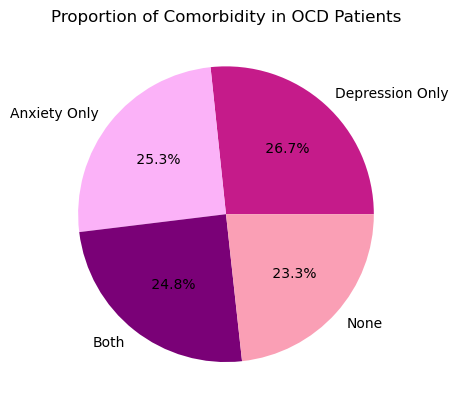

In [10]:
#pie chart
labels = list(colors_comorbid.keys())
pies = preprocessed_df[labels].sum()/preprocessed_df.shape[0]
plt.pie(pies,labels=labels, autopct=lambda x: f"{x: 0.1f}%", colors=list(colors_comorbid.values()))
plt.title("Proportion of Comorbidity in OCD Patients")
plt.show()

In [11]:
pd.DataFrame(preprocessed_df[labels].sum(), columns=["Raw Count"])

,Raw Count
Depression Only,400
Anxiety Only,379
Both,372
None,349


The pie chart and the accompanying table illustrate the proportions and raw counts of OCD patients falling under each of out four comorbidity categories. This overview highlights that comorbidities are relatively evenly distributed with our dataset, with no single group overwhelmingly dominant.

### Age-Wise Prevalence of Comorbidities By Sex

To explore whether age differs across comorbidities and between sexes, we plot a grouped boxplot of Age for each comorbidity category, split by Sex.

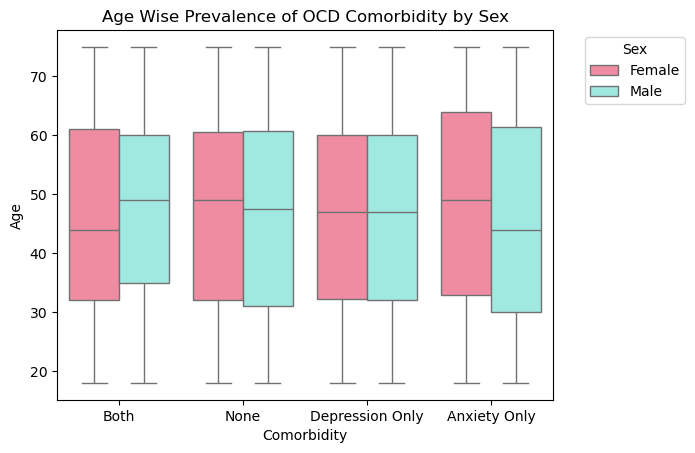

In [12]:
comorbid_df = pd.DataFrame(pd.from_dummies(preprocessed_df[["Depression Only", "Anxiety Only",
                                 "Both", "None"]])).rename(columns={'': "Comorbidity"})
comorbid_sex = pd.concat([pd.from_dummies(preprocessed_df[["Sex_Female","Sex_Male"]], sep="_"), 
                          comorbid_df, preprocessed_df[["Age"]]], axis=1)
box_sex = sns.boxplot(data=comorbid_sex, x="Comorbidity",y="Age", hue="Sex", palette=colors_sex)
box_sex.set_title("Age Wise Prevalence of OCD Comorbidity by Sex")
plt.legend(title='Sex', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


The accompanying table shows the mean age for each combination of comorbidity and sex

In [13]:
comorbid_sex.groupby(["Comorbidity", "Sex"]).mean()


Age
Comorbidity     Sex              
Anxiety Only    Female  48.250000
                Male    45.839572
Both            Female  45.764045
                Male    47.500000
Depression Only Female  46.801980
                Male    46.449495
None            Female  46.828571
                Male    46.718391

This visualization and table reveal subtle differences in age distributions between sexes across comorbidity categories, though no large disparities are apparent.

### Age-Wise Prevalence of Comorbidities by Ethnicity

Similarly, to explore whether age differs across comorbity and between ethnicities, we plot a grouped boxplot of Age for each comorbidity category, split by Ethnicity.

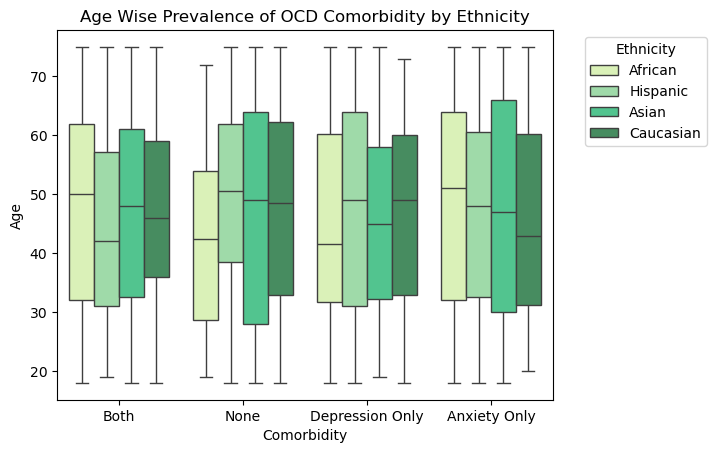

In [14]:
ethn_cols_ind = [i for i, x in enumerate(list(preprocessed_df.columns.str
                        .startswith("Ethnicity_"))) if x == True]
ethn_cols = pd.from_dummies(preprocessed_df.iloc[:, ethn_cols_ind], sep="_")
comorbid_ethn = pd.concat([ethn_cols, comorbid_df, preprocessed_df[["Age"]]], axis=1)
box_ethn = sns.boxplot(data=comorbid_ethn, x="Comorbidity",y="Age", hue="Ethnicity", palette=colors_ethn)
box_ethn.set_title("Age Wise Prevalence of OCD Comorbidity by Ethnicity")
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


The accompanying table shows the mean age for each combination of comorbidity and ethnicity

In [15]:
comorbid_ethn.groupby(["Comorbidity", "Ethnicity"]).mean()

Age
Comorbidity     Ethnicity           
Anxiety Only    African    48.797753
                Asian      46.969072
                Caucasian  46.112245
                Hispanic   46.505263
Both            African    47.600000
                Asian      47.035088
                Caucasian  47.252632
                Hispanic   44.772727
Depression Only African    45.543478
                Asian      45.938776
                Caucasian  46.841584
                Hispanic   47.963303
None            African    41.955882
                Asian      46.519481
                Caucasian  47.596154
                Hispanic   49.390000

The illustrations highlight subtle differences in age distributions by ethnicity across comorbidity categories. While some trends are observable (e.g., the None category shows higher mean age among African patients compared to other ethnicities), no *extreme* disparities are apparent.

### OCD Comorbidities by Education Level

To explore how OCD comorbidity categories are distributed across educational levels, we calculate the proportion of each comorbidity within each education group. Using proportions instead of raw counts allows us to account for differences in group sizes and compare patterns more clearly.

The grouped bar chart below shows the relative distribution of the four comorbidity categories within each education level, and the corresponding table summarizes these proportions.

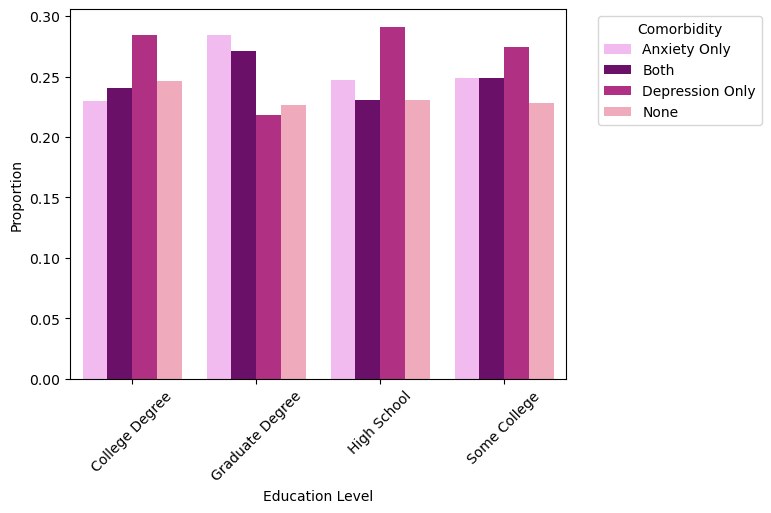

In [16]:
edu_cols_ind = [i for i, x in enumerate(list(preprocessed_df.columns.str
                        .startswith("Education Level_"))) if x == True]
edu_cols = pd.from_dummies(preprocessed_df.iloc[:, edu_cols_ind], sep="_")
comorbid_edu = pd.concat([edu_cols, comorbid_df], axis=1)

comorbid_edu = pd.DataFrame(comorbid_edu.groupby(["Education Level", 
                                    "Comorbidity"]).value_counts())
edu_counts = dict(comorbid_edu.reset_index().groupby("Education Level")["count"].sum())
comorbid_edu = comorbid_edu.reset_index()
props = []
for i in range(comorbid_edu.shape[0]):
    props.append(comorbid_edu["count"][i]/edu_counts[comorbid_edu["Education Level"][i]])
comorbid_edu["Proportion"] = props
comorbid_edu = comorbid_edu.drop(columns=["count"])
sns.barplot(data=comorbid_edu, x="Education Level", hue="Comorbidity", 
            y="Proportion", palette=colors_comorbid)
plt.legend(title='Comorbidity', bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.xticks(rotation=45)
plt.show()

In [17]:
comorbid_edu.groupby(["Education Level", "Comorbidity"]).mean()

Proportion
Education Level Comorbidity                
College Degree  Anxiety Only       0.229508
                Both               0.240437
                Depression Only    0.284153
                None               0.245902
Graduate Degree Anxiety Only       0.284574
                Both               0.271277
                Depression Only    0.218085
                None               0.226064
High School     Anxiety Only       0.247253
                Both               0.230769
                Depression Only    0.291209
                None               0.230769
Some College    Anxiety Only       0.248731
                Both               0.248731
                Depression Only    0.274112
                None               0.228426

We observe that the proportions of comorbidities are fairly balanced across educational levels, with slight observable differences (e.g., except the `Graduate Degree` level, all other education levels have a slightly higher proportion of `Depression Only` patients). However, these differences are not extreme, suggesting that education alone may not strongly differentiate OCD comorbidity categories.

### OCD Comorbidity by Marital Status

We also examine how OCD comorbidity categories distribute across different marital status groups. Again, proportions are calculated within each marital status to account for differences in group sizes, allowing for a clear comparison of comorbidity patterns.

The grouped bar chart below shows the relative distribution of the four comorbidity categories for each marital status, and the corresponding table summarizes these proportions:

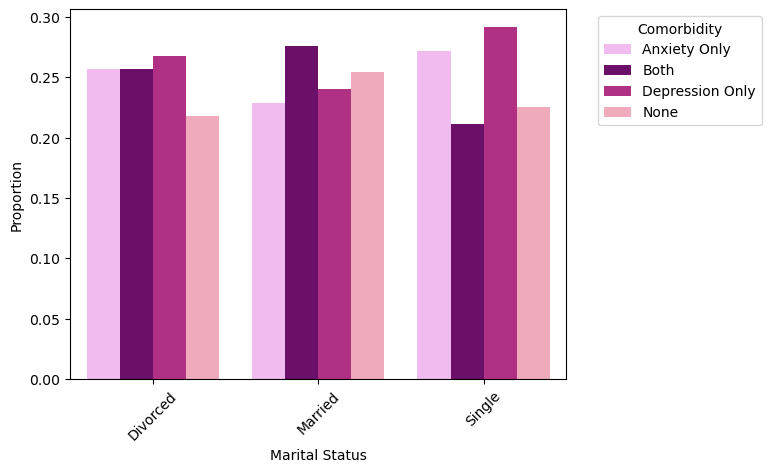

In [18]:
marital_cols_ind = [i for i, x in enumerate(list(preprocessed_df.columns.str
                        .startswith("Marital Status_"))) if x == True]
marital_cols = pd.from_dummies(preprocessed_df.iloc[:, marital_cols_ind], sep="_")
comorbid_marital = pd.concat([marital_cols, comorbid_df], axis=1)
comorbid_marital = pd.DataFrame(comorbid_marital.groupby(["Marital Status", 
                                    "Comorbidity"]).value_counts())
marital_counts = dict(comorbid_marital.reset_index().groupby("Marital Status")["count"].sum())
comorbid_marital = comorbid_marital.reset_index()
props = []
for i in range(comorbid_marital.shape[0]):
    props.append(comorbid_marital["count"][i]/marital_counts[comorbid_marital["Marital Status"][i]])
comorbid_marital["Proportion"] = props
comorbid_marital = comorbid_marital.drop(columns=["count"])
sns.barplot(data=comorbid_marital, x="Marital Status", hue="Comorbidity", 
            y="Proportion", palette=colors_comorbid)
plt.legend(title='Comorbidity', bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.xticks(rotation=45)
plt.show()

In [19]:
comorbid_marital.groupby(["Marital Status", "Comorbidity"]).mean()

Proportion
Marital Status Comorbidity                
Divorced       Anxiety Only       0.257261
               Both               0.257261
               Depression Only    0.267635
               None               0.217842
Married        Anxiety Only       0.228797
               Both               0.276134
               Depression Only    0.240631
               None               0.254438
Single         Anxiety Only       0.272016
               Both               0.211350
               Depression Only    0.291585
               None               0.225049

It becomes clear that comorbidity distributions are fairly similar across marital statuses, though `Depression Only` appears slightly higher among `Single` patients, while `Both` is higher among `Married` patients. Overall, again, no dramatic differences are observed.

### OCD Comorbidities by Gender x Ethnicity

To explore potential interactions between gender and ethnicity in OCD comorbidity patterns, we create a heatmap showing the proportion of each comorbidity category within every Gender × Ethnicity combination. Proportions are calculated within each subgroup to account for differences in sample size.

The heatmap uses color intensity to represent the relative prevalence of the four comorbidity categories (`Depression Only`, `Anxiety Only`, `Both`, `None`) for each combination of Gender (`Female`, `Male`) and Ethnicity (`African`, `Asian`, `Caucasian`, `Hispanic`).

In [20]:
ctab_ethn_sex = pd.concat([comorbid_df, comorbid_sex[["Sex"]], 
          comorbid_ethn[["Ethnicity"]]], axis=1)

ctab_ethn_sex = pd.crosstab([ctab_ethn_sex["Ethnicity"], ctab_ethn_sex["Sex"]],
                            ctab_ethn_sex["Comorbidity"])
for row in ctab_ethn_sex.index:
    row_total = ctab_ethn_sex.loc[row].sum()
    ctab_ethn_sex.loc[row] = ctab_ethn_sex.loc[row].apply(lambda x: x/ row_total)
ctab_ethn_sex.T

C:\Users\tanis\AppData\Local\Temp\ipykernel_16752\213564493.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.31724137931034485' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ctab_ethn_sex.loc[row] = ctab_ethn_sex.loc[row].apply(lambda x: x/ row_total)
C:\Users\tanis\AppData\Local\Temp\ipykernel_16752\213564493.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2206896551724138' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ctab_ethn_sex.loc[row] = ctab_ethn_sex.loc[row].apply(lambda x: x/ row_total)
C:\Users\tanis\AppData\Local\Temp\ipykernel_16752\213564493.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25517241379310346' has dtype incompati

Ethnicity         African               Asian           Caucasian            \
Sex                Female      Male    Female      Male    Female      Male   
Comorbidity                                                                   
Anxiety Only     0.317241  0.240223  0.220096  0.288136  0.266010  0.225641   
Both             0.220690  0.240223  0.291866  0.299435  0.221675  0.256410   
Depression Only  0.255172  0.307263  0.263158  0.242938  0.256158  0.251282   
None             0.206897  0.212291  0.224880  0.169492  0.256158  0.266667   

Ethnicity        Hispanic            
Sex                Female      Male  
Comorbidity                          
Anxiety Only     0.242105  0.242574  
Both             0.210526  0.237624  
Depression Only  0.305263  0.252475  
None             0.242105  0.267327

In [21]:
ctab_hmap = ctab_ethn_sex.reset_index()
ctab_hmap["Ethnicity"] = ctab_hmap["Ethnicity"] + " + " + ctab_hmap["Sex"]
ctab_hmap = ctab_hmap.rename(columns={"Ethnicity": 
                        "Ethnicity & Sex"}).set_index("Ethnicity & Sex")
ctab_hmap = ctab_hmap.drop(columns=["Sex"])
ctab_hmap = ctab_hmap.T

trace_hmap = go.Heatmap(
    z=ctab_hmap.values,
    x=ctab_hmap.columns,
    y=ctab_hmap.index,
    colorscale=colors_hmap)

fig_hmap = go.Figure(data=[trace_hmap])
fig_hmap.update_layout(title_text="OCD Comorbidity by Gender × Ethnicity")
fig_hmap.show()


While no Gender x Ethnicity combination overwhelmingly dominates any one comorbidity category, the heatmap does provide some interesting insights, such as:

1. <u>Distinct Peaks for `Depression Only`</u><br>
`African Males` and `Hispanic Females` show pronounced proportions for the 'Depression Only' condition, together accounting for roughly 61% of all 'Depression Only' OCD patients.

2. <u>High `Anxiety Only` in `African Females`</u><br> 
Roughly 32% of all 'Anxiety Only' OCD-patients are African Females`, suggesting the possibility of anxiety being a predominant comorbidity among this subgroup.

3. <u>`Both` Condition Prominance in Asians</u><br>
`Asian Females` and `Asian Males` show higher proportions of 'Both' (Anxiety & Depression comorbidities) category, together accounting for roughly 59% of all 'Both' Anxiety and Depression OCD patients. Further, Asian Males are the lowest occupants of the `None` comorbidity category.

**Note: It is important to bear in mind that this is a synthetic dataset; therefore, the observed patterns should not be interpreted as conclusive evidence of real-world trends.**

### OCD Comorbidities by Education × Marital Status

Each subgroup is defined by one specific combination of an education level, a marital status, and a comorbidity category. 
1. The mosaic plot is divided into 4 main columns along the x-axis, each representing one education level.<br> 
2. Each of these main columns is further divided into three squares along the y-axis, one for each marital status.<br> 
2. Within each of these squares are 4 colored bars, each representing one comorbidity condition. 

The rule of interpretation is as follows: the more space a particular comorbidity bar takes up within the square (i.e., the wider the comorbidity bar), the more prevalent that comorbidity condition is among OCD patients of a specific education level and marital status combination. 

In addition to the visual perspective provided by the mosaic plot, we also include a crosstabulation alongside to provide a quantitative perspective. While the mosaic plot emphasizes relative group sizes and visual patterns, the crosstab highlights the exact distribution of comorbidities across education × marital status combinations.

C:\Users\tanis\AppData\Local\Temp\ipykernel_16752\1830659295.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



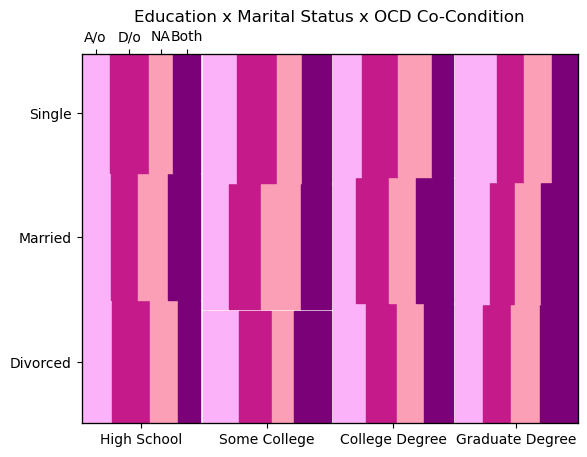

In [22]:
mosaic_df = pd.concat([comorbid_df, marital_cols,edu_cols], axis=1)
ctab_mosaic_df = pd.crosstab(mosaic_df["Comorbidity"], 
                [mosaic_df["Education Level"], mosaic_df["Marital Status"]])
education_ordinal = ["High School", "Some College", "College Degree", "Graduate Degree"]

comorbid_order = ["Anxiety Only", "Depression Only", "None", "Both"]
marital_order = ["Single", "Divorced", "Married"]

mosaic_df["Education Level"] = pd.Categorical(mosaic_df["Education Level"], 
                                                 categories=education_ordinal,
                                                 ordered=True)
mosaic_df["Comorbidity"] = pd.Categorical(mosaic_df["Comorbidity"], 
                                                 categories=comorbid_order,
                                                 ordered=True)
map_comorbid= {"Depression Only": "D/o", "Anxiety Only": "A/o", 
               "Both": "Both", "None": "NA"}
mosaic_df["Comorbidity"] = mosaic_df["Comorbidity"].apply(lambda x: map_comorbid[x])
mosaic_colors = {}
for color_key, map_key in zip(colors_comorbid, map_comorbid):
    mosaic_colors[map_comorbid[map_key]] = colors_comorbid[color_key]
mosaic_df = mosaic_df.groupby(["Education Level", "Marital Status", 
                                     "Comorbidity"]).size()
mosaic(mosaic_df,
       labelizer=lambda label: "",properties=lambda dimen_tup: {"color": mosaic_colors[dimen_tup[-1]]})
plt.title("Education x Marital Status x OCD Co-Condition")
plt.show()



In [23]:
ctab_mosaic_df

Education Level College Degree                Graduate Degree                 \
Marital Status        Divorced Married Single        Divorced Married Single   
Comorbidity                                                                    
Anxiety Only                32      23     29              27      35     45   
Both                        29      38     21              37      37     28   
Depression Only             31      35     38              28      25     29   
None                        27      28     35              29      27     29   

Education Level High School                Some College                 
Marital Status     Divorced Married Single     Divorced Married Single  
Comorbidity                                                             
Anxiety Only             31      31     28           34      27     37  
Both                     23      34     27           35      31     32  
Depression Only          39      28     39           31      34     43  
None                     28      32     24           21      42     27

The mosaic plot of Education × Marital Status against Comorbidity categories does not suggest any strong associations. The distribution of colors within each cell is more or less consistent, indicating that the relative proportions of comorbidity categories remain stable across education levels and marital statuses.

No monotonic trend is visible with education: moving from `High School` through `Graduate Degree`, none of the comorbidity categories shows a consistent rise or fall. Likewise, within each education level, `Single`, `Married`, and `Divorced` groups display similar profiles, suggesting little to no interaction between education and marital status in shaping comorbidity outcomes.

While a few cells (e.g., Divorced × Graduate Degree) show slightly wider bands for one category, these variations are small, inconsistent, and likely attributable to sampling noise, especially given the synthetic nature of the dataset. Overall, the mosaic plot implies that education and marital status contribute minimally, if at all, to predicting comorbidity status in OCD.

### OCD Patients Through Ethnicity, Education Level, Marital Status: A Flow to OCD Comorbidity

As the final step in our exploratory data analysis, we use a Sankey diagram to visualize how patients progress through multiple demographic categories: Ethnicity → Education Level → Marital Status → Comorbidity Category. This diagram provides a holistic view of the dataset, showing the distribution and flow of patients across these factors in a single visualization.

The width of each flow corresponds to the number of patients in that pathway, offering insight into subgroup sizes and potential patterns. Note that this diagram reflects raw counts, so differences may be influenced by sample sizes rather than strong associations.

In [24]:
sankey_df = pd.concat([
    comorbid_df, edu_cols, ethn_cols, marital_cols
], axis=1).groupby(["Ethnicity", "Education Level", 
                    "Marital Status", "Comorbidity"]).size()\
.reset_index(name="Count")

#identifying all unique nodes
nodes = pd.concat([sankey_df["Ethnicity"],sankey_df["Education Level"],
           sankey_df["Marital Status"],sankey_df["Comorbidity"]]).unique().tolist()

#assigning numeric IDs to each node
node_id = {name: id for id, name in enumerate(nodes)}

#counting the flows for each of the three stages

#stage 1: ethnicity --> education
stage_1 = sankey_df[["Ethnicity", "Education Level", 
                     "Count"]].groupby(["Ethnicity", 
                        "Education Level"]).sum().reset_index()

#stage 2: education --> marital status
stage_2 = sankey_df[["Education Level", "Marital Status",
                     "Count"]].groupby(["Education Level",
                        "Marital Status"]).sum().reset_index()

#stage 3: marital status --> co-occuring condition
stage_3 = sankey_df[["Marital Status", "Comorbidity",
                     "Count"]].groupby(["Marital Status",
                            "Comorbidity"]).sum().reset_index()

#creating source, target, value lists
source_stage_1 = stage_1["Ethnicity"].apply(lambda x: node_id[x]).tolist()
target_stage_1 = stage_1["Education Level"].apply(lambda x: node_id[x]).tolist()
vals_stage_1 = stage_1["Count"].tolist()

source_stage_2 = stage_2["Education Level"].apply(lambda x: node_id[x]).tolist()
target_stage_2 = stage_2["Marital Status"].apply(lambda x: node_id[x]).tolist()
vals_stage_2 = stage_2["Count"].tolist()

source_stage_3 = stage_3["Marital Status"].apply(lambda x: node_id[x]).tolist()
target_stage_3 = stage_3["Comorbidity"].apply(lambda x: node_id[x]).tolist()
vals_stage_3 = stage_3["Count"].tolist()

#combines all source, target, and value lists
sources = source_stage_1 + source_stage_2 + source_stage_3
targets = target_stage_1 + target_stage_2 + target_stage_3
vals = vals_stage_1 + vals_stage_2 + vals_stage_3

#plot the sankey diagram using plotly

#color code the nodes and the flows
node_colors_dict = colors_comorbid
node_colors_dict.update(colors_ethn)
node_colors_dict.update(colors_edu)
node_colors_dict.update(colors_marital)


node_colors = [node_colors_dict[node] for node in nodes]
flow_colors = []

for tgt in targets:
    for node in node_colors_dict.keys():
        if node_id[node] == tgt:
            flow_colors.append(node_colors_dict[node])


fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=vals,
        color=flow_colors
    )
)])
fig.update_layout(title="Flow of OCD Patients Across Demographic and Comorbidity Categories")
fig.show()


While no single path overwhelmingly dominates, the Sankey diagram highlights some subtle flows from Ethnicity the demographic conditions to OCD Comorbidity, such as:

1. <u>Education Distribution</u><br>
While education levels are relatively balanced across ethnic groups, some subtle differences emerge. For example, there is an observable difference in the proportion of Graduate Degree holders who are Caucasians compared to those who are Africans. Further, except High School, all other education levels see African OCD patients having the lowest representation among all ethnicities. However, further investigation is required to judge whether this trend is systematic or due to sampling differences.<br>  

2. <u>Marital Status Flow</u><br>
Married and Divorced individuals receive almost equal contributions from all education levels, while the Single category is comprised of a slightly higher share of patients with Some College or Graduate Degrees.<br>

3. <u>Comorbidity Distribution</u><br><br>
Single patients predominantly flow into the Depression Only or Anxiety Only categories, and are also the highest occupants of both these categories. On the other hand, Married patients serve as the highest occupants of the Both and None categories. Divorced patients see an almost equal flow into the  Depression Only, Anxiety Only, or Both categories, with a slightly lower flow into the None category.<br>

These are just a few observations from the Sankey diagram, and more can be explored by hovering over the different flows in this interactive plot. Again, it is important to note that the Sankey diagram shows raw counts, so observed differences may be influenced by sample size. And as noted previously, the synthetic nature of this dataset makes patterns illustrative rather than clinically meaningful.

## Modeling and Prediction

Based on the trends observed in the EDA, no strong association between demographic factors and OCD comorbidity is anticipated in this dataset. Nevertheless, to provide a conclusive check, we perform a few baseline predictive modeling approaches. These models serve to confirm the patterns suggested by the EDA.

Should any of these models uncover unexpected patterns or predictive power, further modeling techniques may be explored, although such outcomes are not expected given the insights from the exploratory analysis.

### Logistic Regression

We begin our modeling with Logistic Regression, since it serves as a natural first step for multi-class classification problems. Logistic regression provides interpretable coefficients that allow us to assess how each demographic factor contributes to predicting OCD comorbidity categories. By starting with this baseline model, we can establish a reference point before considering more complex techniques.

Since our categorical features (`Sex`, `Ethnicity`, `Education Level`, `Marital Status`) were already one-hot encoded early on, no additional encoding is required at this stage. The only feature still requiring transformation is `Age`, which must be normalized to ensure it is on a comparable scale with the binary categorical indicators. We apply StandardScaler to center the Age feature around zero with unit variance.

In [25]:
scalar = StandardScaler()
preprocessed_df["Age"] = scalar.fit_transform(preprocessed_df[["Age"]])
preprocessed_df.head()

,Age,Depression Only,Anxiety Only,Both,None,Sex_Female,Sex_Male,Ethnicity_African,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Hispanic,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Education Level_College Degree,Education Level_Graduate Degree,Education Level_High School,Education Level_Some College
0,-0.878549,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1
1,1.320597,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1
3,-1.175731,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0
5,-0.878549,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0
9,1.498907,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0


We drop the columns corresponding to the perdictor variable of Comorbidity from our features dataset. 

In [26]:
X = preprocessed_df.drop(columns=comorbid_order)
y = comorbid_df["Comorbidity"]

With the dataset prepared, we move on to training the logistic regression model. Since our target variable (Comorbidity) has four possible outcomes (`Depression Only`, `Anxiety Only`, `Both`, and `None`), we use the multinomial setting rather than the simpler binary case for our model.

We split the dataset into training and testing sets using a stratified split to preserve the class distribution across both subsets. This ensures that the less frequent categories remain represented during training and evaluation.

The logistic regression model is configured with the LBFGS solver and an increased iteration cap (max_iter=500). This adjustment prevents premature convergence issues that can occur when handling multiple features or imbalanced data.

Finally, we evaluate the model using the classification report (precision, recall, and F1-score per class) and the confusion matrix, which together provide a comprehensive picture of how well the model predicts each comorbidity category.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42 #HGTTG :)
)
model = LogisticRegression(multi_class="multinomial",solver="lbfgs",
                           max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

                 precision    recall  f1-score   support

   Anxiety Only       0.22      0.22      0.22        76
           Both       0.23      0.23      0.23        74
Depression Only       0.31      0.46      0.37        80
           None       0.25      0.10      0.14        70

       accuracy                           0.26       300
      macro avg       0.25      0.25      0.24       300
   weighted avg       0.25      0.26      0.24       300

[[17 25 26  8]
 [28 17 22  7]
 [19 18 37  6]
 [15 15 33  7]]


c:\Users\tanis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



The logistic regression model achieves an overall accuracy of 26%, which is barely above random guessing for a four-class problem. Examination of the classification report and confusion matrix shows that the model struggles to correctly predict most categories, with modest performance only for `Depression Only` (F1-score = 0.37). Other comorbidity categories (`Anxiety Only`, `Both`, `None`) have low precision and recall, indicating that the model is unable to reliably distinguish between them.

These results are consistent with the trends observed during EDA: there are no strong linear associations between the demographic variables and OCD comorbidity in this dataset.

Since logistic regression captures linear relationships, it may miss non-linear interactions between features and comorbidity outcomes. To account for potential non-linear patterns and interactions, we next train a Random Forest classifier, which can model complex dependencies. It also reduces the risk of overfitting compared to a single decision tree. However, given the weak signals observed in EDA, significant improvement is not expected.

### Random Forest

As with logistic regression, the features consist of standardized age and one-hot encoded categorical variables (`Sex`, `Ethnicity`, `Marital Status`, `Education Level`). The target variable remains the multi-class comorbidity status (`Anxiety Only`, `Depression Only`, `Both`, `None`).

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
rf_model = RandomForestClassifier(
    n_estimators=100,        # number of trees
    max_depth=None,          # full depth
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

                 precision    recall  f1-score   support

   Anxiety Only       0.20      0.22      0.21        76
           Both       0.27      0.28      0.28        74
Depression Only       0.26      0.24      0.25        80
           None       0.20      0.19      0.19        70

       accuracy                           0.23       300
      macro avg       0.23      0.23      0.23       300
   weighted avg       0.23      0.23      0.23       300

[[17 23 16 20]
 [20 21 16 17]
 [24 21 19 16]
 [23 12 22 13]]


The Random Forest model too shows poor predictive performance, achieving an overall accuracy of 23%. This, in fact, is slightly worse than the 26% accuracy from logistic regression. Given that random guessing for a four-class problem would yield around 25%, this result again indicates the lack of any meaningful patterns.

### K-Means Clustering

To further explore whether any hidden structure exists in the data, we apply K-Means clustering. Unlike supervised models, K-Means does not use the target labels but instead attempts to partition the data into distinct groups based on the features alone.

By setting 4 clusters - each corresponding to the four comorbidity categories - we check whether any natural groupings of OCD comorbidities emerge based on demographic features. This serves as a final sanity check following the Logistic Regression and Random Forest results, helping confirm whether any latent patterns exist in the demographic features that were not captured in the supervised models.

In [29]:
kmeans_df = X.copy()
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)
kmeans_df["Cluster"] = clusters
kmeans_df["Comorbidity"] = y
kmeans_df.head()

,Age,Sex_Female,Sex_Male,Ethnicity_African,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Hispanic,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Education Level_College Degree,Education Level_Graduate Degree,Education Level_High School,Education Level_Some College,Cluster,Comorbidity
0,-0.878549,1,0,1,0,0,0,0,0,1,0,0,0,1,2,Both
1,1.320597,0,1,1,0,0,0,1,0,0,0,0,0,1,1,Both
3,-1.175731,1,0,0,0,0,1,0,1,0,1,0,0,0,2,Both
5,-0.878549,1,0,0,1,0,0,0,1,0,1,0,0,0,2,Both
9,1.498907,1,0,0,0,0,1,1,0,0,0,1,0,0,0,Both


In [30]:
kmeans_df.groupby("Cluster")["Comorbidity"].value_counts(normalize=True).unstack()

Comorbidity,Anxiety Only,Both,Depression Only,None
Cluster,,,,
0,0.274611,0.207254,0.264249,0.253886
1,0.218667,0.274667,0.266667,0.240000
2,0.238227,0.271468,0.277008,0.213296
3,0.277778,0.240741,0.259259,0.222222


The table of proportions shows that all clusters have a very similar composition of `Anxiety Only`, `Depression Only`, `Both`, and `None`. No demographic-based cluster strongly corresponds to a particular comorbidity, and the minor differences observed are small and likely reflect sampling variability.

This confirms the patterns observed in the EDA and predictive modeling: **demographic variables in this dataset do not appear to meaningfully separate OCD patients by comorbidity status.**

## Conclusion

In this project, we explored whether demographic factors - age, sex, ethnicity, education level, and marital status - could meaningfully predict OCD comorbidity status (Anxiety Only, Depression Only, Both, None) using a synthetic dataset of 1,500 simulated patients.

The exploratory data analysis indicated that OCD comorbidity distributions are relatively balanced across demographic groups. Visualizations such as the heatmap, mosaic plot, and sankey diagram revealed no strong or consistent patterns. Minor differences, such as slightly higher proportions of Depression Only among certain sex-ethnicity combinations or subtle flows in education and marital status, were observed, but these differences were inconsistent and likely attributable to sampling variability rather than systematic trends.

Predictive modeling further confirmed these findings. Logistic regression achieved only 26% accuracy, and Random Forests achieved 23% accuracy - both at or below the level of random guessing for a four-class classification problem. K-means clustering similarly failed to uncover any meaningful clusters aligned with comorbidity categories. Across EDA, modeling, and clustering, demographic variables did not appear to provide predictive or explanatory power regarding OCD comorbidities in this synthetic dataset.

Overall, this project showcases a structured approach to combining descriptive and predictive analytics for multi-class outcomes, while also acknowledging the limitations of the dataset. The analyses highlight the importance of careful interpretation, especially with synthetic data, and provide a workflow that could be applied to real-world datasets where stronger associations might exist.